<a href="https://colab.research.google.com/github/jkorzy/colab/blob/main/stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
%pip install -q seaborn

In [43]:
# Mathematical library
import math

# Data manipulation libraries
import numpy as np
import pandas as pd

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.style.use('ggplot')

# Utility libraries
import warnings
warnings.filterwarnings('ignore')
import os
import datetime as dt

Read data

In [91]:
data = pd.read_csv("gpw/pkn_d.csv")

resultOffset = 5
data['Result'] = 0

for i in range( len(data)-resultOffset ) :
  data.at[i, 'Result'] = data.loc[i + resultOffset, 'Zamkniecie']

data.drop(data.tail(resultOffset).index, inplace=True)

data['Date']=pd.to_datetime(data['Data']).dt.date
data.set_index("Date",inplace=True)
data = data.iloc[:, 1:]

In [74]:
data.shape

(6195, 6)

In [92]:
data.tail(15)

,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,Result
Date,,,,,,
2024-07-26,64.00,64.32,63.58,63.75,831520.0,63.40
2024-07-29,64.50,64.79,63.90,64.29,748396.0,61.10
2024-07-30,64.30,64.59,63.22,63.22,937584.0,61.39
2024-07-31,63.77,64.74,63.52,64.67,2016737.0,61.12
2024-08-01,64.74,64.74,63.36,63.38,958144.0,62.24
2024-08-02,63.20,63.61,62.88,63.40,1146391.0,61.56
2024-08-05,62.00,62.05,59.90,61.10,3116018.0,64.56
2024-08-06,61.70,62.38,60.87,61.39,1868083.0,63.71
2024-08-07,62.00,62.00,60.90,61.12,1367599.0,62.98


Usuwanie niepotrzebnych kolumn - Otwarcie, Najwyzszy, Najniższy

In [82]:
data.drop(['Otwarcie', 'Najwyzszy', 'Najnizszy'], axis=1, inplace=True)
data.head()

,Zamkniecie,Wolumen,Result
Date,,,
1999-11-26,13.3511,1.804577e+07,14.1991
1999-11-29,13.1130,6.258260e+06,14.7413
1999-11-30,13.3511,3.740809e+06,14.5014
1999-12-01,13.7729,3.502574e+06,14.6208
1999-12-02,14.0189,3.760073e+06,14.5014


In [93]:
# Store date information for plotting
dates = data.index

# Scale the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [94]:
data_scaled

array([[0.04675211, 0.04648   , 0.04358954, 0.04532489, 1.        ,
        0.05441112],
       [0.04540304, 0.04451881, 0.04489588, 0.04277367, 0.34327331,
        0.06022074],
       [0.04480262, 0.0457953 , 0.04687819, 0.04532489, 0.20301665,
        0.05765024],
       ...,
       [0.59602311, 0.59611864, 0.59086528, 0.58491548, 0.06996962,
        0.58673701],
       [0.5840787 , 0.58725269, 0.58402973, 0.5770936 , 0.06740122,
        0.56691445],
       [0.58610499, 0.58874815, 0.59346929, 0.58834425, 0.07835048,
        0.57795079]])

In [95]:
# Define a function to create sequences of input data and labels
def create_sequences(data, sequence_length, target_column):
    x, y = [], []
    for i in range(len(data) - sequence_length - 1):
        x.append(data[i: i + sequence_length])
        y.append(data[i + sequence_length, target_column])
    return np.array(x), np.array(y)

In [96]:
# Create input sequences and labels
sequence_length = 5  # Nd is the number of days in the sequence, to predict next day's (Nd+1) closing price   <--- "Nd" defined at the beginning of the script (step 0)
target_column = 2  # Assuming 'Close' is the first column in the dataset
x, y = create_sequences(data_scaled, sequence_length, target_column)

# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, shuffle=False)

In [97]:
x_train[0], y_train[0]

(array([[0.04675211, 0.04648   , 0.04358954, 0.04532489, 1.        ,
         0.05441112],
        [0.04540304, 0.04451881, 0.04489588, 0.04277367, 0.34327331,
         0.06022074],
        [0.04480262, 0.0457953 , 0.04687819, 0.04532489, 0.20301665,
         0.05765024],
        [0.04733334, 0.04902443, 0.04815633, 0.04984443, 0.18974365,
         0.05892959],
        [0.05190634, 0.05487168, 0.05340994, 0.0524803 , 0.20408989,
         0.05765024]]),
 0.054105430637407345)

Definicja modelu

In [98]:
input_layer = Input(shape=(sequence_length, data.shape[1]))
lstm_layer = LSTM(150)(input_layer)
output_layer = Dense(1)(lstm_layer)

model = Model(inputs=input_layer, outputs=output_layer)

Trening modelu

In [99]:
model.compile(optimizer="adam", loss="mean_squared_error")

batch_size = 8
epochs = 15  # Adjust the number of epochs according to your needs
model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

Epoch 1/15
619/619 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0024
Epoch 2/15
619/619 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.0581e-04
Epoch 3/15
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 1.0689e-04
Epoch 4/15
619/619 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 7.5676e-05
Epoch 5/15
619/619 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 7.5136e-05
Epoch 6/15
619/619 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 6.3018e-05
Epoch 7/15
619/619 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 9.7279e-05
Epoch 8/15
619/619 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 5.0709e-05
Epoch 9/15
619/619 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.5330e-05
Epoch 10/15
619/619 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 5.8434e-05
Epoch 11/15
619/619 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 5.3650e-05
Epoch 12/15
619/619 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 5.5127e-05
Epoch 13/15
619/619 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 3.7069e-05
Epoch 14/15
619/619 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 4.2105e-05
Epoch

Prediction

In [100]:
y_train_pred = model.predict(x_train)
y_test_pred = model.predict(x_test)

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [101]:
y_train_true = scaler.inverse_transform(np.hstack(
    (y_train.reshape(-1, 1), np.zeros((y_train.shape[0], data.shape[1] - 1)))))
y_test_true = scaler.inverse_transform(np.hstack(
    (y_test.reshape(-1, 1), np.zeros((y_test.shape[0], data.shape[1] - 1)))))
y_train_pred = scaler.inverse_transform(np.hstack(
    (y_train_pred, np.zeros((y_train_pred.shape[0], data.shape[1] - 1)))))
y_test_pred = scaler.inverse_transform(
    np.hstack((y_test_pred, np.zeros((y_test_pred.shape[0], data.shape[1] - 1)))))


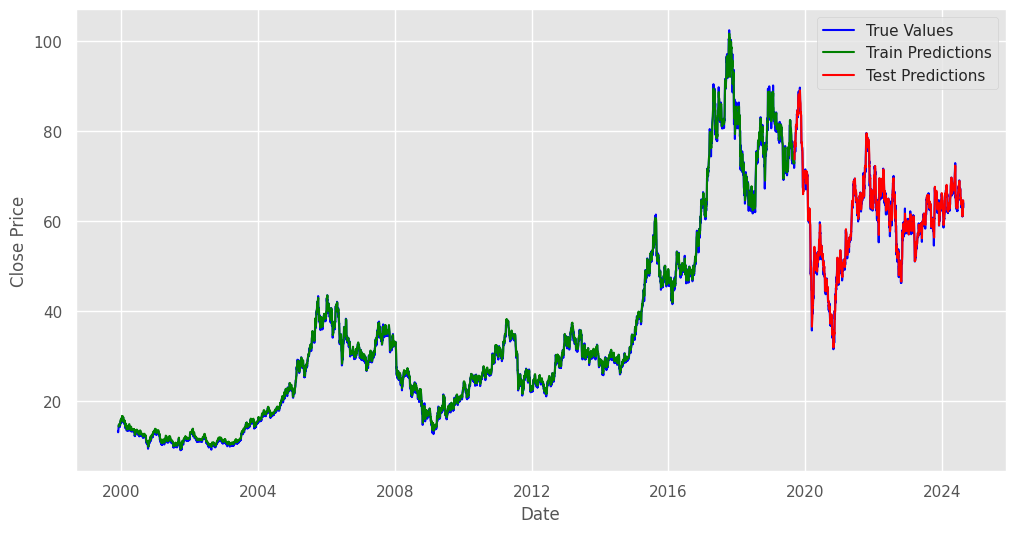

In [102]:
plt.figure(figsize=(12, 6))
plt.plot(dates, data['Zamkniecie'], label='True Values', color='blue')
plt.plot(dates[sequence_length:len(y_train) + sequence_length],
         y_train_pred[:, 0], label='Train Predictions', color='green')
plt.plot(dates[len(y_train) + sequence_length:len(y_train) + len(y_test) +
         sequence_length], y_test_pred[:, 0], label='Test Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

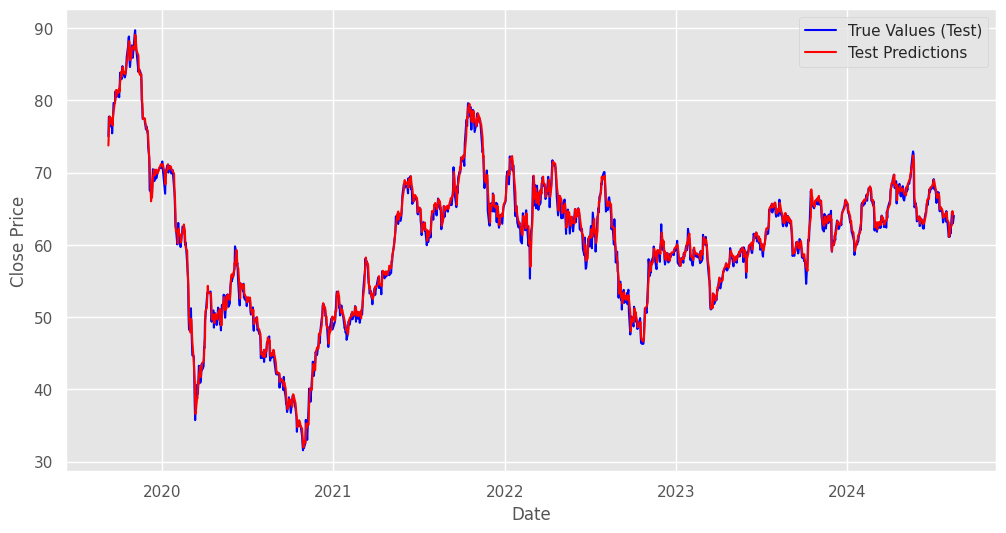

In [103]:
plt.figure(figsize=(12, 6))
plt.plot(dates[len(y_train) + sequence_length:], data['Zamkniecie'][len(y_train) + sequence_length:], label='True Values (Test)', color='blue')
plt.plot(dates[len(y_train) + sequence_length:len(y_train) + len(y_test) + sequence_length], y_test_pred[:, 0], label='Test Predictions', color='red')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()